In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            layer.bias.initializer.run(session=session)

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [4]:
def correlation(x, y):
    x0 = x - np.mean(x, axis = 0)
    y0 = y - np.mean(y, axis = 0)
    return np.mean(x0 * y0, axis = 0) / np.sqrt((np.mean(x0**2, axis = 0) * (np.mean(y0**2, axis = 0))))

# Extracting SST, ONI and Anomaly

In [5]:
datapath = '~/nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

In [6]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [7]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [8]:
clm = climatology(nino34)

In [9]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [13]:
anm = SST_anomaly(nino34, clm)
oni = ONI(anm)
time = np.arange(anm.shape[0])

In [35]:
T = 12

# Per Month

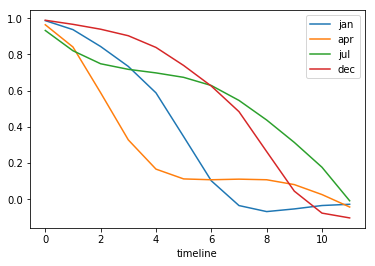

In [57]:
persistance_corr = np.zeros(T)
month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'oct', 'nov', 'dec']

for mon in range(0, 12, 3):
    for t in range(1, T + 1):
        
        maxl = oni[(mon + t)::12].shape[0]
        persistance_corr[t - 1] = correlation(oni[mon::12][0:maxl], oni[(mon + t)::12])
        
    plt.plot(persistance_corr, label = month[mon]);
    plt.xlabel('timeline');
    plt.legend();

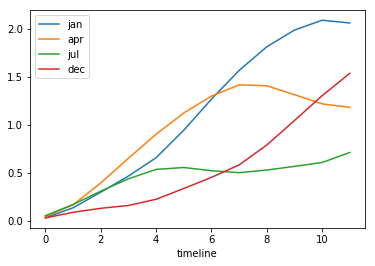

In [58]:
persistance_mse = np.zeros(T)

for mon in range(0, 12, 3):
    for t in range(1, T + 1):
        
        maxl = oni[(mon + t)::12].shape[0]
        persistance_mse[t - 1] = mean_squared_error(oni[mon::12][0:maxl], oni[(mon + t)::12])

    plt.plot(persistance_mse, label = month[mon]);
    plt.xlabel('timeline');
    plt.legend();

# Per Season

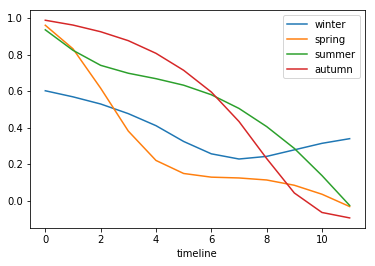

In [59]:
persistance_corr = np.zeros(T)
season = ['winter', 'spring', 'summer', 'autumn']

for mon in range(-1, 9, 3):
    for t in range(1, T + 1):
        
        maxl1 = oni[(mon + t)::12].shape[0]
        maxl2 = oni[(mon + t + 1)::12].shape[0]
        maxl3 = oni[(mon + t + 2)::12].shape[0]
        
        past = np.hstack((oni[(mon % 12)::12][0:maxl1], oni[(mon + 1)::12][0:maxl2], oni[(mon + 2)::12][0:maxl3]))
        pred = np.hstack((oni[(mon + t)::12], oni[(mon + t + 1)::12], oni[(mon + t + 2)::12]))
        
        persistance_corr[t - 1] = correlation(past, pred)
        persistance_mse[t - 1] = mean_squared_error(past, pred)
        
    plt.plot(persistance_corr, label = season[(mon + 1) // 3]);
    plt.xlabel('timeline');
    plt.legend();

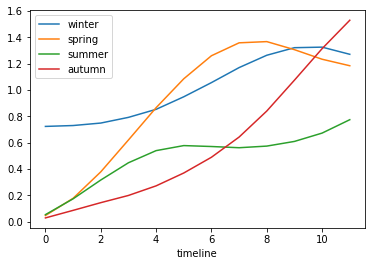

In [56]:
persistance_mse = np.zeros(T)

for mon in range(-1, 9, 3):
    for t in range(1, T + 1):
        
        maxl1 = oni[(mon + t)::12].shape[0]
        maxl2 = oni[(mon + t + 1)::12].shape[0]
        maxl3 = oni[(mon + t + 2)::12].shape[0]
        
        past = np.hstack((oni[(mon % 12)::12][0:maxl1], oni[(mon + 1)::12][0:maxl2], oni[(mon + 2)::12][0:maxl3]))
        pred = np.hstack((oni[(mon + t)::12], oni[(mon + t + 1)::12], oni[(mon + t + 2)::12]))
    
        persistance_mse[t - 1] = mean_squared_error(past, pred)
        
    plt.plot(persistance_mse, label = season[(mon + 1) // 3]);
    plt.xlabel('timeline');
    plt.legend();

# Per Window

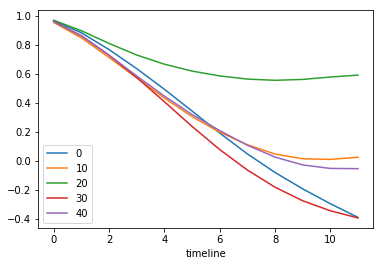

In [76]:
persistance_corr = np.zeros(T)
length = oni.shape[0] // 50

for start in range(0, oni.shape[0] - length, 10 * length):
    for t in range(1, T + 1):
        
        persistance_corr[t - 1] = correlation(oni[start:(start + length)], oni[(start + t):(start + t + length)])
        
    plt.plot(persistance_corr, label = start // length);
    plt.xlabel('timeline');
    plt.legend();

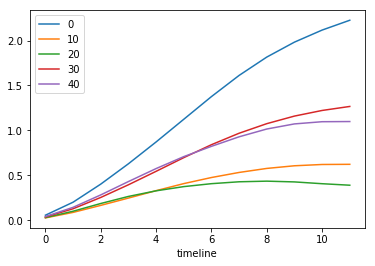

In [77]:
persistance_mse = np.zeros(T)

for start in range(0, oni.shape[0] - length, 10 * length):
    for t in range(1, T + 1):
        
        persistance_mse[t - 1] = mean_squared_error(oni[start:(start + length)], oni[(start + t):(start + t + length)])
        
    plt.plot(persistance_mse, label = start // length);
    plt.xlabel('timeline');
    plt.legend();